In [54]:
import pandas as pd
import ast
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results_paths = [
	'coarse_gs_results_giulia1.csv',
	'coarse_gs_results_giulia800_1.csv',
 	'coarse_gs_results_giulia800_2.csv',
 	'coarse_gs_results_giulia800_3.csv',
 	'coarse_gs_results_giulia800_4.csv',
	'coarse_gs_results_irene1.csv',
	'coarse_gs_results_irene2.csv',
	'coarse_gs_results_lorenzo1.csv',
 	'coarse_gs_results_lorenzo2.csv',
	'coarse_gs_results_lorenzo3.csv',
	'coarse_gs_results_lorenzo4.csv',
	'coarse_gs_results_lorenzo5.csv'
]
MEE = 'MEE'
MSE = 'MSE'
N_MODELS = 1656
K = 3

# concatenate results into a single dataframe
scores_df = pd.DataFrame(columns=[])
for path in results_paths:
	partial_scores_df = pd.read_csv(path, sep=",")
	scores_df = pd.concat([scores_df, partial_scores_df], ignore_index=True)

########### SWAP COLUMNS ##########

# NOTE: delete for the fine grid search!

# val_mee_mean <--> val_mse_mean
# val_mee_dev <--> val_mse_dev
# splitX_val_mee <--> split0_val_mse

scores_df = scores_df.rename(
	columns = {
	"val_mee_mean": "val_MSE_mean",
	"val_mee_dev": "val_MSE_dev",
	"split0_val_mee": "split0_val_MSE",
	"split1_val_mee": "split1_val_MSE",
	"split2_val_mee": "split2_val_MSE",
	"val_mse_mean" : "val_MEE_mean",
	"val_mse_dev" : "val_MEE_dev",
	"split0_val_mse" : "split0_val_MEE",
	"split1_val_mse" : "split1_val_MEE",
	"split2_val_mse" : "split2_val_MEE"
	}
)

###########################################

# rank results
scores_df['val_%s_mean_rank'%MEE] = rankdata(scores_df['val_%s_mean'%MEE], method='dense')
scores_df['val_%s_mean_rank'%MSE] = rankdata(scores_df['val_%s_mean'%MSE], method='dense')
scores_df['tr_mee_mean_rank'] = rankdata(scores_df['tr_mee_mean'], method='dense')
scores_df['tr_mse_mean_rank'] = rankdata(scores_df['tr_mse_mean'], method='dense')

# sort results by 'val_score_mean_rank'
scores_df = scores_df.sort_values(by=['val_%s_mean_rank'%MEE], ignore_index=True)
scores_df.drop(scores_df.columns[0], axis=1, inplace=True)

columns_order = [
	'val_%s_mean_rank'%MSE,
	'val_%s_mean'%MSE,
	'val_%s_dev'%MSE,
	'val_%s_mean_rank'%MEE,
	'val_%s_mean'%MEE,
	'val_%s_dev'%MEE,
	'tr_mse_mean_rank',
	'tr_mse_mean',
	'tr_mse_dev',
	'tr_mee_mean_rank',
	'tr_mee_mean',
	'tr_mee_dev',
]
for i in range(K):
	columns_order.append('split%d_val_%s'%(i, MSE))
	columns_order.append('split%d_val_%s'%(i, MEE))
	columns_order.append('split%d_tr_mse'%(i))
	columns_order.append('split%d_tr_mee'%(i))
	columns_order.append('split%d_best_epoch'%(i))
columns_order.append('params')
scores_df = scores_df[columns_order]

# write params as csv deleting fixed params
rem_list = [ 
	'activation_out',
	'classification',
	'early_stopping',
	'evaluation_metric',
	'loss',
	'metric_decrease_tol',
	'random_state',
	'reinit_weights',
	'stopping_patience',
	'tau',
	'tol',
	'validation_size',
	'verbose',
	'weights_bound',
	'weights_dist'
	]
params_df = pd.DataFrame(columns=[])
for param in scores_df['params']: # TODO: fare in modo migliore?
	params_dict = ast.literal_eval(param)
	for key in rem_list:
		del params_dict[key]
		params_dict['batch_size'] = str(params_dict['batch_size'])
	params_df = pd.concat([params_df, pd.DataFrame([params_dict])], ignore_index=True)


params_df['val_MEE_mean'] = scores_df['val_MEE_mean']
params_df['val_MEE_dev'] = scores_df['val_MEE_dev']
params_df['tr_mee_mean'] = scores_df['tr_mee_mean']
params_df['val_MEE_mean_rank'] = scores_df['val_MEE_mean_rank']
params_df['split0_val_MEE'] = scores_df['split0_val_MEE']
params_df['split1_val_MEE'] = scores_df['split1_val_MEE']
params_df['split2_val_MEE'] = scores_df['split2_val_MEE']
params_df['split0_best_epoch'] = scores_df['split0_best_epoch']
params_df['split1_best_epoch'] = scores_df['split1_best_epoch']
params_df['split2_best_epoch'] = scores_df['split2_best_epoch']

hidden_layer_sizes = []
for i in range(1656):
	if (params_df['hidden_layer_sizes'][i]) == [30, 30, 30]:
		hidden_layer_sizes.append('3layer30')
	elif (params_df['hidden_layer_sizes'][i]) == [30, 30]:
		hidden_layer_sizes.append('2layer30')
	else:
		hidden_layer_sizes.append('2layer60')
params_df['hidden'] = hidden_layer_sizes

learning_rate = []
for i in range(1656):
	if (params_df['learning_rate'][i]) == 'fixed':
		if (params_df['learning_rate_init'][i]) == 0.0001:
			learning_rate.append('fixed_0.0001')
		elif (params_df['learning_rate_init'][i]) == 0.0005:
			learning_rate.append('fixed_0.0005')
		elif (params_df['learning_rate_init'][i]) == 0.001:
			learning_rate.append('fixed_0.001')
		else:
			learning_rate.append('fixed_0.1')
	else:
		if (params_df['learning_rate_init'][i]) == 0.0005:
			learning_rate.append('lin_dec_0.0005')
		elif (params_df['learning_rate_init'][i]) == 0.001:
			learning_rate.append('lin_dec_0.001')
		else:
			learning_rate.append('lin_dec_0.1')
params_df['lr'] = learning_rate

params_df

,activation_hidden,alpha,batch_size,epochs,hidden_layer_sizes,lambd,learning_rate,learning_rate_init,nesterov,val_MEE_mean,...,tr_mee_mean,val_MEE_mean_rank,split0_val_MEE,split1_val_MEE,split2_val_MEE,split0_best_epoch,split1_best_epoch,split2_best_epoch,hidden,lr
0,logistic,0.8,1,800,"[60, 60]",0.00010,fixed,0.0001,False,1.453951e+00,...,1.283675e+00,1,1.554779e+00,1.361701e+00,1.445373e+00,797.0,448.0,685.0,2layer60,fixed_0.0001
1,logistic,0.8,64,200,"[30, 30, 30]",0.00100,linear_decay,0.1000,False,1.455967e+00,...,1.185249e+00,2,1.571828e+00,1.415476e+00,1.380599e+00,192.0,174.0,183.0,3layer30,lin_dec_0.1
2,logistic,0.5,64,200,"[30, 30, 30]",0.00100,linear_decay,0.1000,True,1.456580e+00,...,1.313219e+00,3,1.548998e+00,1.395117e+00,1.425626e+00,161.0,159.0,161.0,3layer30,lin_dec_0.1
3,logistic,0.8,1,200,"[30, 30, 30]",0.00100,fixed,0.0005,False,1.458648e+00,...,1.265118e+00,4,1.532175e+00,1.387878e+00,1.455892e+00,193.0,185.0,184.0,3layer30,fixed_0.0005
4,logistic,0.8,64,200,"[60, 60]",0.00010,linear_decay,0.1000,False,1.459499e+00,...,1.146128e+00,5,1.560241e+00,1.424121e+00,1.394135e+00,198.0,199.0,195.0,2layer60,lin_dec_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,tanh,0.8,64,800,"[60, 60]",0.00100,linear_decay,0.1000,True,5.580045e+22,...,1.750101e+21,1652,5.880307e+08,4.927116e+17,1.674009e+23,0.0,0.0,0.0,2layer60,lin_dec_0.1
1652,tanh,0.8,64,200,"[60, 60]",0.00010,fixed,0.1000,True,7.202453e+22,...,1.048780e+21,1653,3.694886e+07,1.369484e+15,2.160736e+23,0.0,0.0,0.0,2layer60,fixed_0.1
1653,tanh,0.8,64,800,"[60, 60]",0.00010,linear_decay,0.1000,True,1.939229e+23,...,2.581905e+21,1654,2.221682e+08,1.377641e+15,5.817688e+23,0.0,0.0,0.0,2layer60,lin_dec_0.1
1654,tanh,0.8,64,800,"[60, 60]",0.00010,fixed,0.1000,True,1.268670e+24,...,2.154621e+22,1655,8.528561e+07,2.220493e+16,3.806009e+24,0.0,0.0,0.0,2layer60,fixed_0.1


<AxesSubplot:xlabel='alpha', ylabel='activation_hidden'>

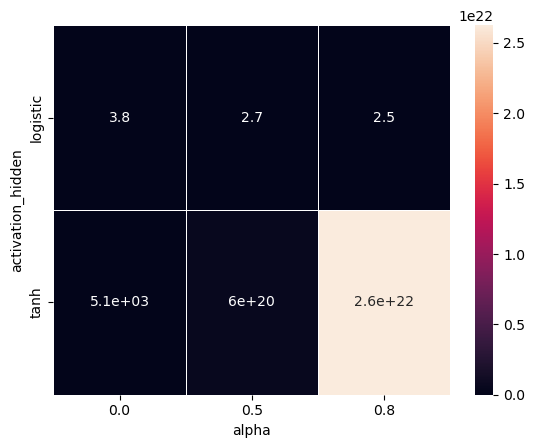

In [3]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='alpha'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='batch_size', ylabel='activation_hidden'>

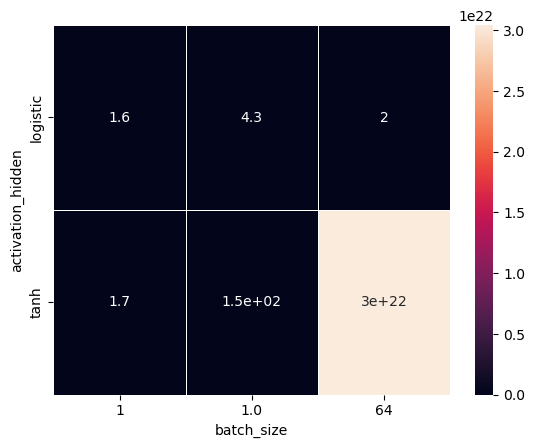

In [4]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='batch_size'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)


<AxesSubplot:xlabel='epochs', ylabel='activation_hidden'>

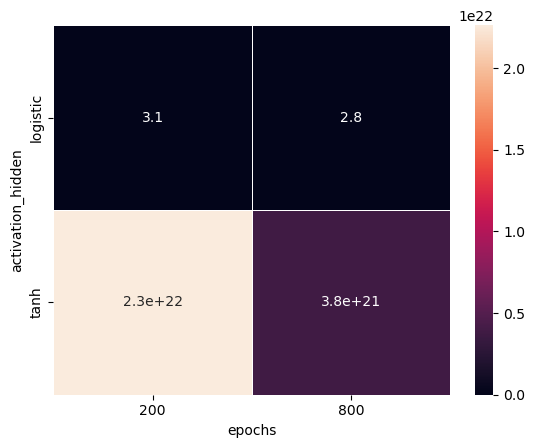

In [5]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='epochs'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='hidden', ylabel='activation_hidden'>

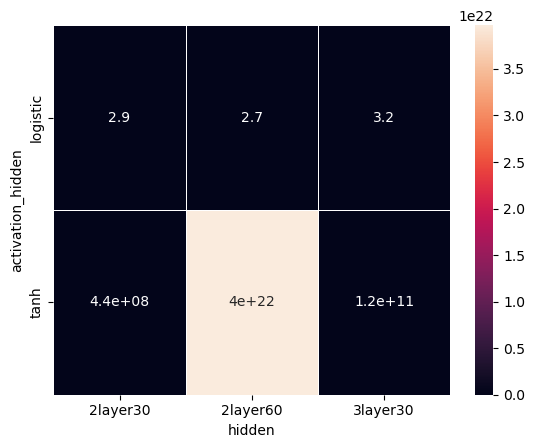

In [6]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='hidden'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='activation_hidden'>

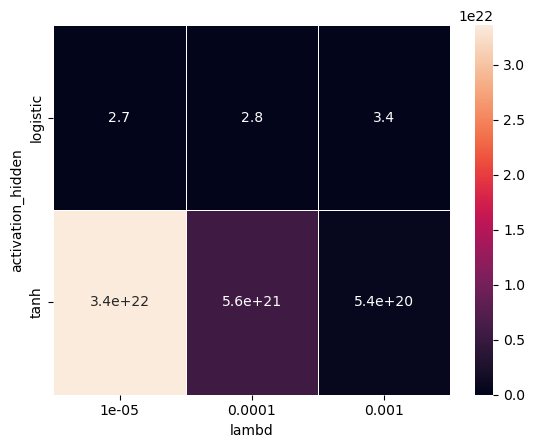

In [7]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='activation_hidden'>

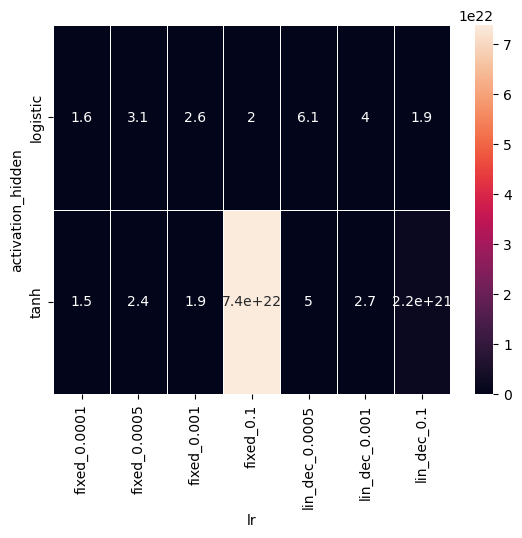

In [8]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='batch_size', ylabel='alpha'>

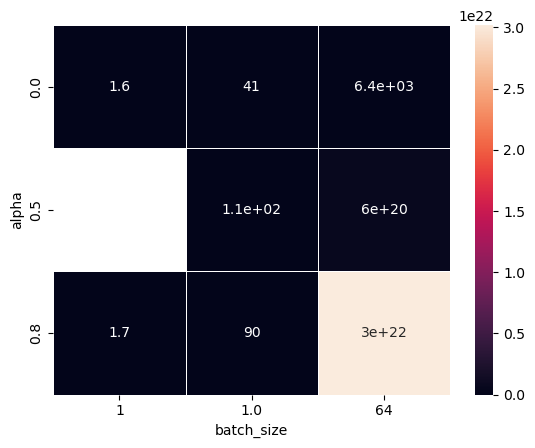

In [9]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='batch_size'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='epochs', ylabel='alpha'>

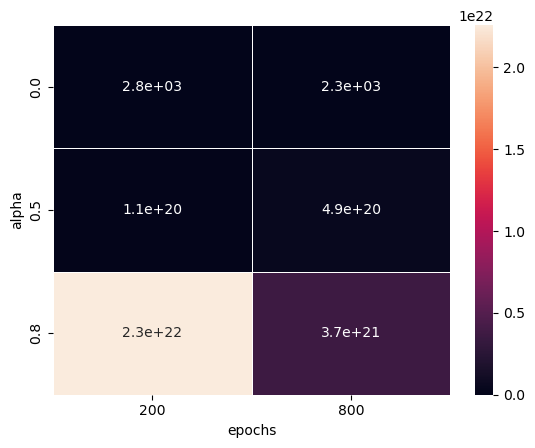

In [10]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='epochs'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='hidden', ylabel='alpha'>

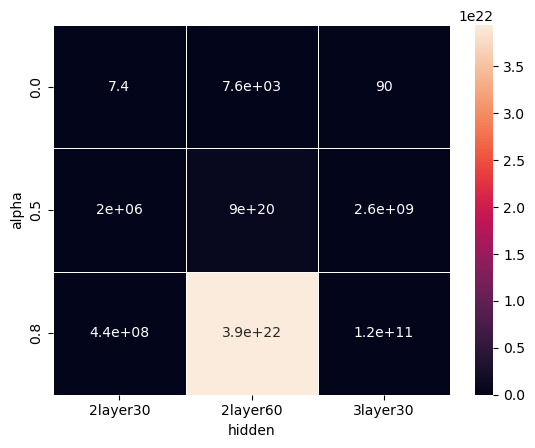

In [11]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='hidden'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='alpha'>

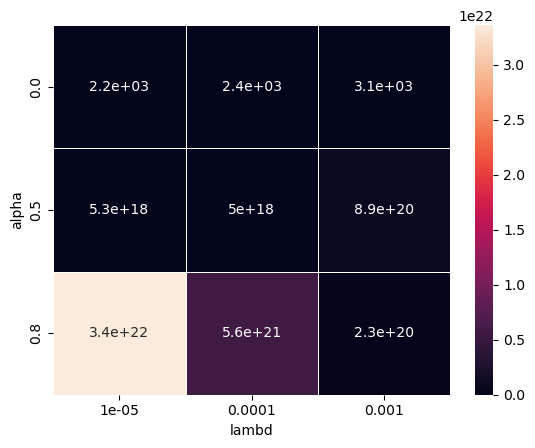

In [12]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='alpha'>

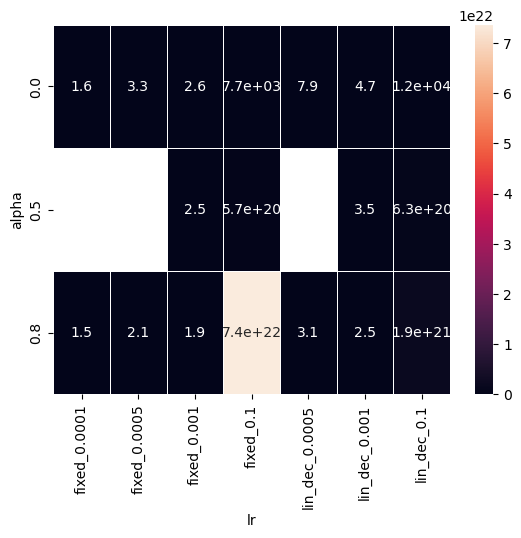

In [13]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='epochs', ylabel='batch_size'>

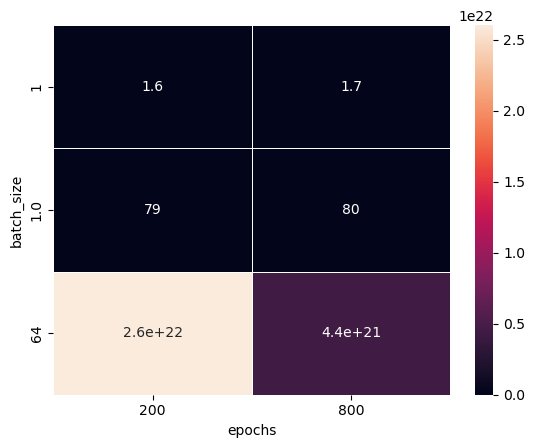

In [14]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='batch_size',
        columns='epochs'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='hidden', ylabel='batch_size'>

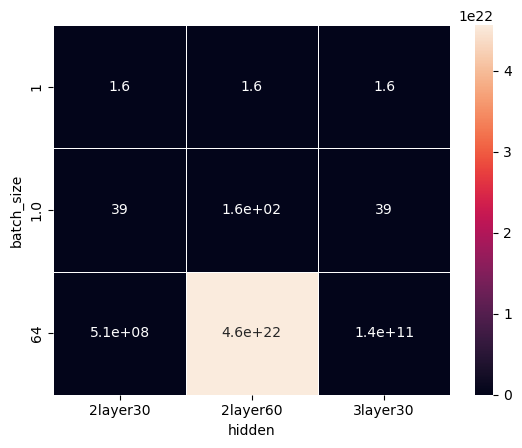

In [15]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='batch_size',
        columns='hidden'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='batch_size'>

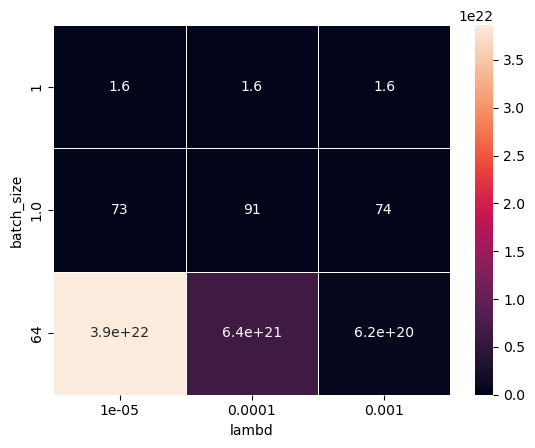

In [16]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='batch_size',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='batch_size'>

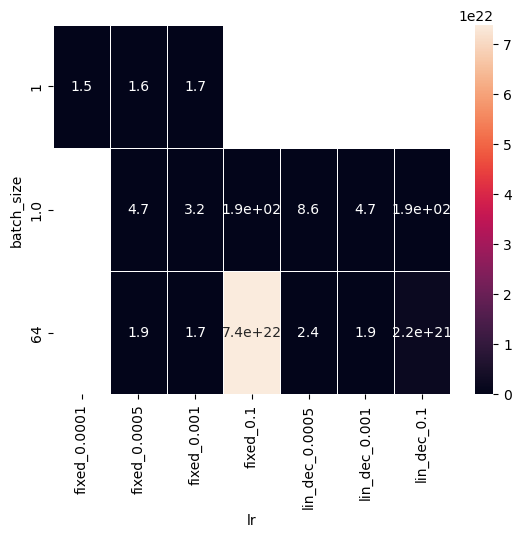

In [17]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='batch_size',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='hidden', ylabel='epochs'>

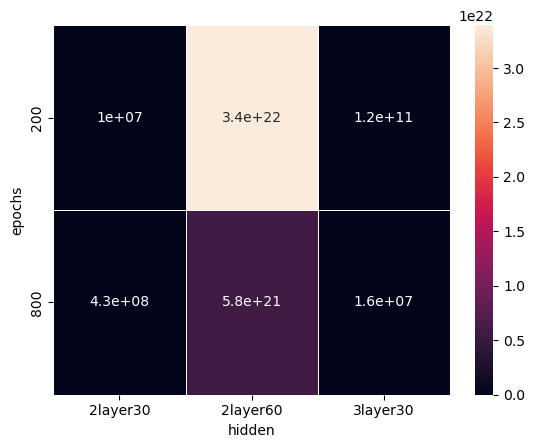

In [18]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='epochs',
        columns='hidden'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='epochs'>

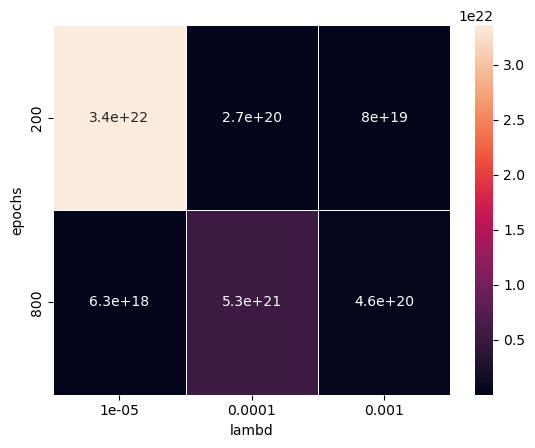

In [19]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='epochs',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='epochs'>

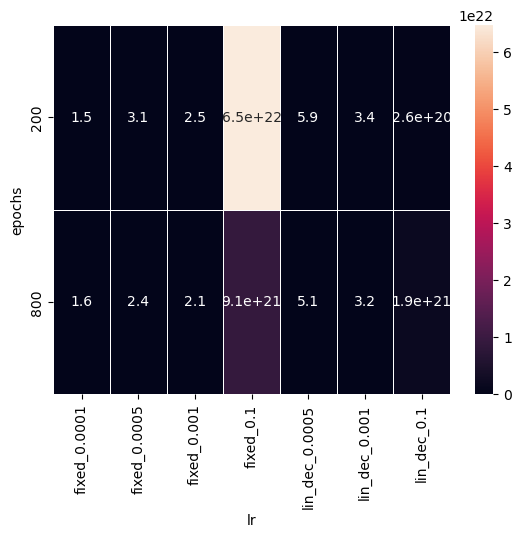

In [20]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='epochs',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='hidden'>

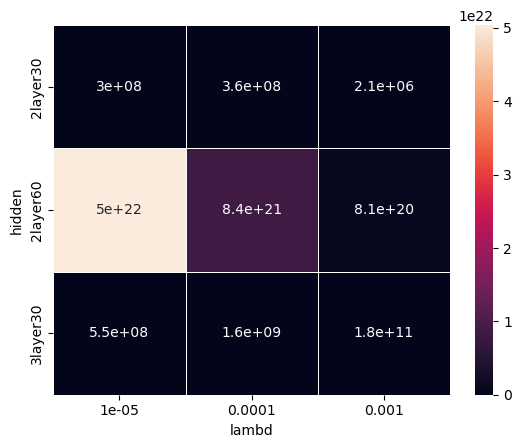

In [21]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='hidden',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='hidden'>

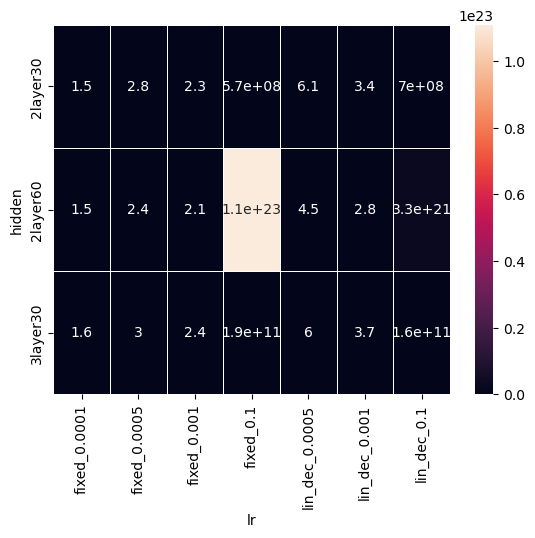

In [22]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='hidden',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='lr'>

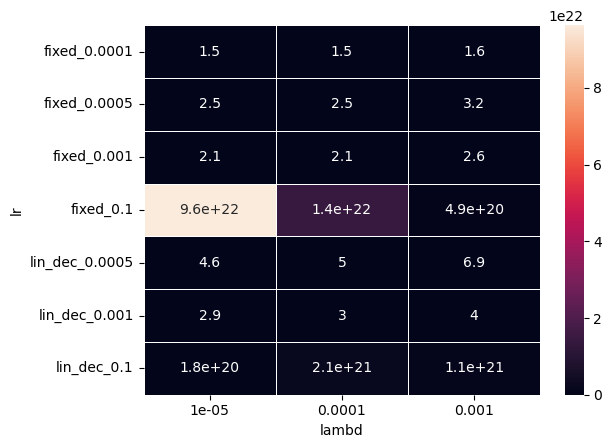

In [23]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='lr',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

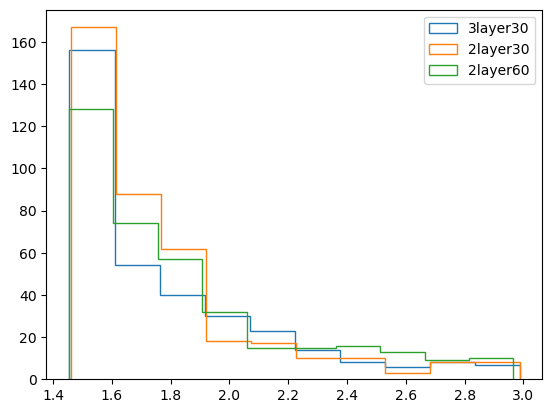

In [24]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['hidden']=='3layer30')], histtype='step', label='3layer30')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['hidden']=='2layer30')], histtype='step', label='2layer30')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['hidden']=='2layer60')], histtype='step', label='2layer60')
plt.legend()

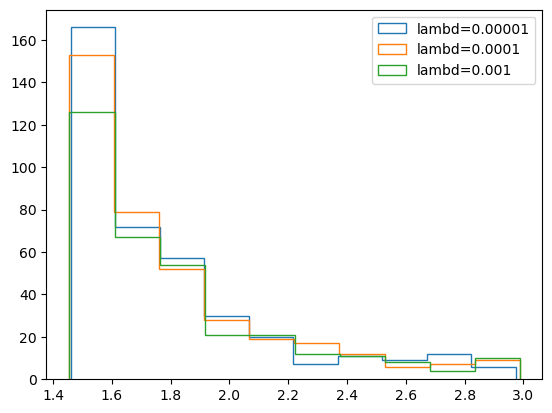

In [25]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['lambd']==0.00001)], histtype='step', label='lambd=0.00001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['lambd']==0.0001)], histtype='step', label='lambd=0.0001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['lambd']==0.001)], histtype='step', label='lambd=0.001')
plt.legend()

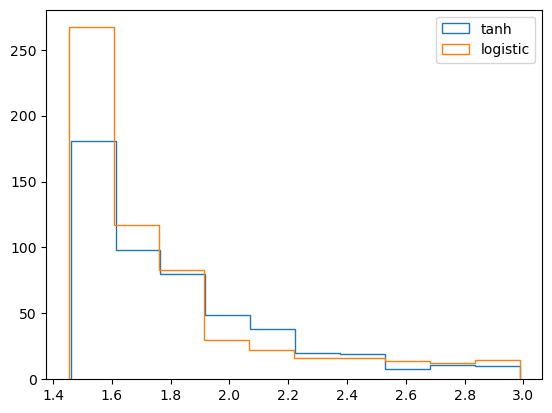

In [26]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['activation_hidden']=='tanh')], histtype='step', label='tanh')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['activation_hidden']=='logistic')], histtype='step', label='logistic')
plt.legend()

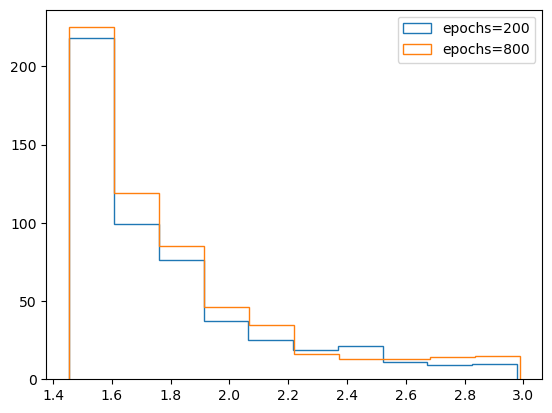

In [27]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['epochs']==200)], histtype='step', label='epochs=200')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['epochs']==800)], histtype='step', label='epochs=800')
plt.legend()

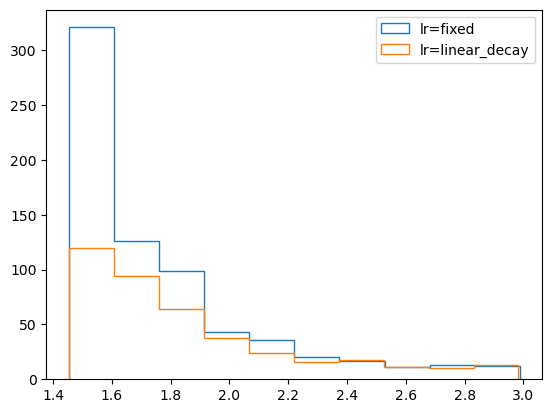

In [28]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate']=='fixed')], histtype='step', label='lr=fixed')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate']=='linear_decay')], histtype='step', label='lr=linear_decay')
plt.legend()

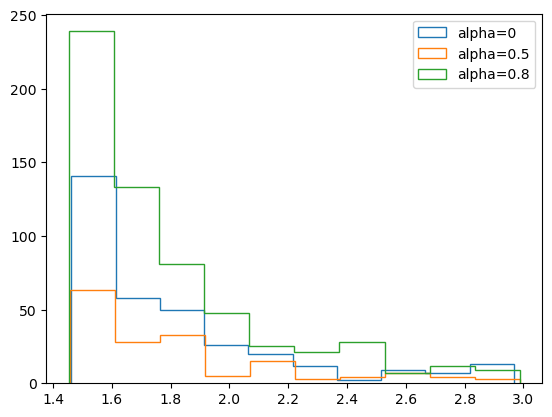

In [29]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['alpha']==0)], histtype='step', label='alpha=0')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['alpha']==0.5)], histtype='step', label='alpha=0.5')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['alpha']==0.8)], histtype='step', label='alpha=0.8')
plt.legend()

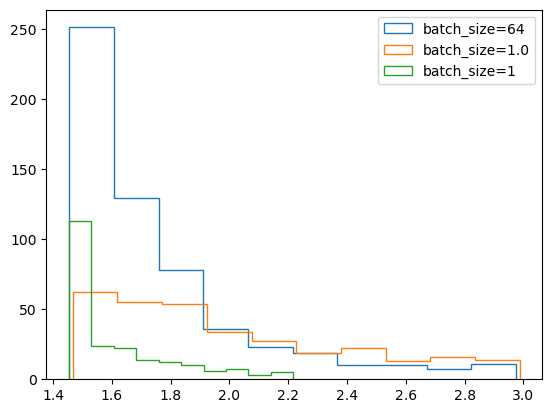

In [30]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['batch_size']=='64')], histtype='step', label='batch_size=64')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['batch_size']=='1.0')], histtype='step', label='batch_size=1.0')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['batch_size']=='1')], histtype='step', label='batch_size=1')
plt.legend()

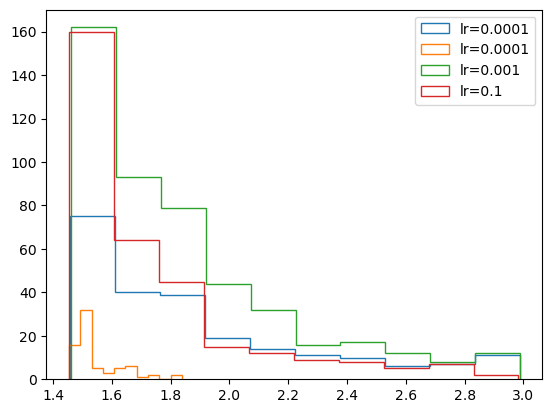

In [31]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate_init']==0.0005)], histtype='step', label='lr=0.0001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate_init']==0.0001)], histtype='step', label='lr=0.0001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate_init']==0.001)], histtype='step', label='lr=0.001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate_init']==0.1)], histtype='step', label='lr=0.1')
plt.legend()


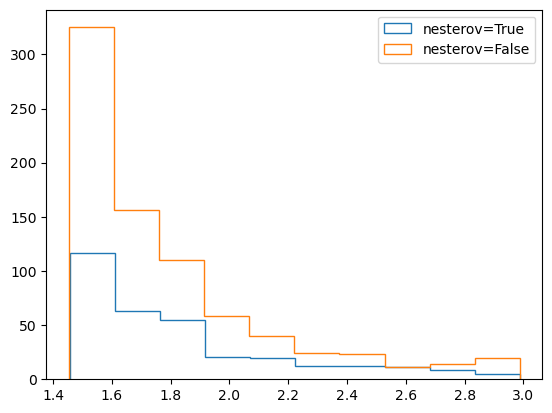

In [32]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['nesterov']==True)], histtype='step', label='nesterov=True')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['nesterov']==False)], histtype='step', label='nesterov=False')
plt.legend()

Text(0, 0.5, 'val_MEE_mean')

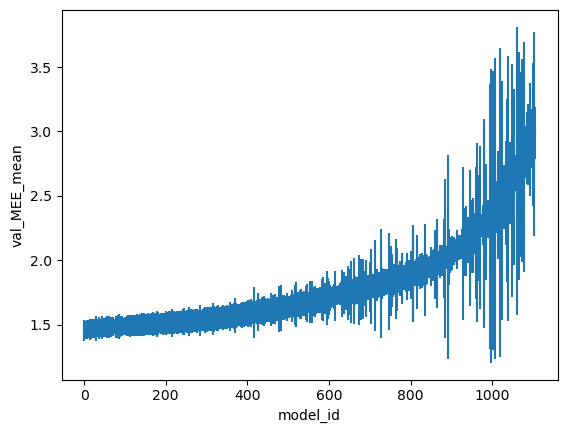

In [33]:
y = params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3)]
yerr = params_df['val_MEE_dev'][(params_df['val_MEE_mean']<3)]
n_models = len(y)
plt.errorbar(x=np.arange(n_models), y=y, yerr=yerr)
plt.xlabel("model_id")
plt.ylabel("val_MEE_mean")

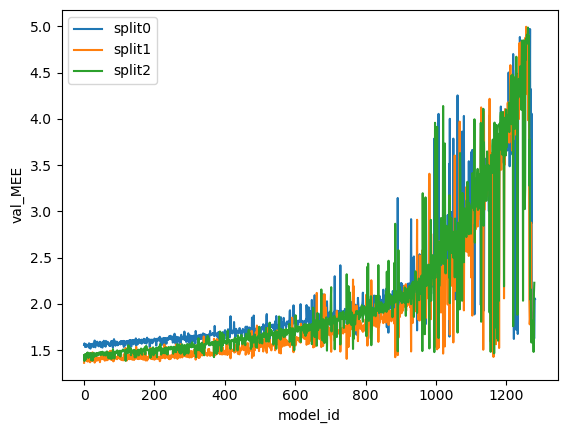

In [34]:
y0=params_df['split0_val_MEE'][(params_df['split0_val_MEE']<5)]
n0=np.arange(len(y0))
y1=params_df['split1_val_MEE'][(params_df['split1_val_MEE']<5)]
n1=np.arange(len(y1))
y2=params_df['split2_val_MEE'][(params_df['split2_val_MEE']<5)]
n2=np.arange(len(y2))

plt.plot(n0, y0, label='split0')
plt.plot(n1, y1, label='split1')
plt.plot(n2, y2, label='split2')
plt.xlabel("model_id")
plt.ylabel("val_MEE")
plt.legend()

Text(0.5, 1.0, 'mean best epoch frequency when max 200')

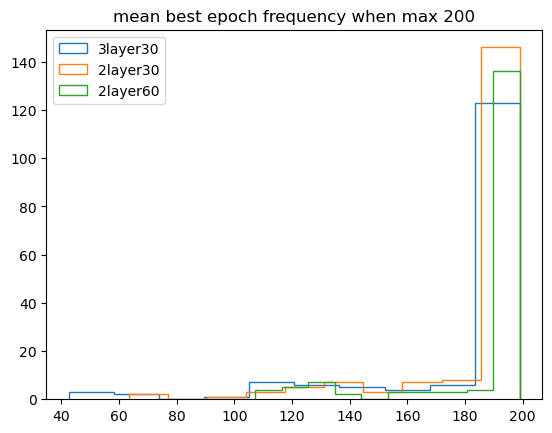

In [35]:
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==200)])/3
		,histtype='step',label='3layer30')
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==200)])/3
		,histtype='step',label='2layer30')
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==200)])/3
		,histtype='step',label='2layer60')
plt.legend()
plt.title('mean best epoch frequency when max 200')

Text(0.5, 1.0, 'mean best epoch frequency when max 800')

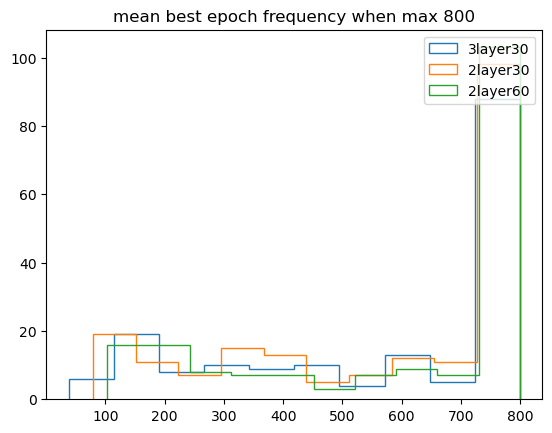

In [36]:
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==800)])/3
		,histtype='step',label='3layer30')
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==800)])/3
		,histtype='step',label='2layer30')
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==800)])/3
		,histtype='step',label='2layer60')
plt.legend()
plt.title('mean best epoch frequency when max 800')

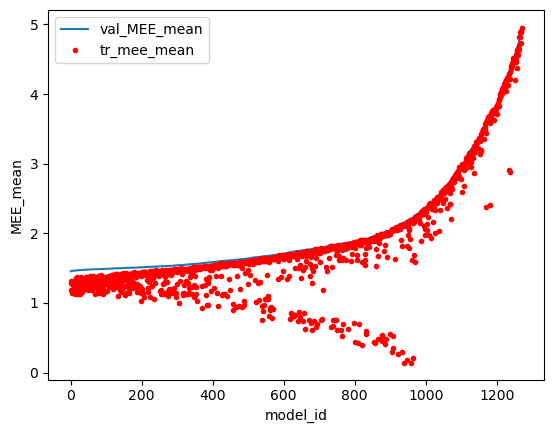

In [52]:
y_val = params_df['val_MEE_mean'][(params_df['val_MEE_mean']<5)]
y_tr = params_df['tr_mee_mean'][(params_df['val_MEE_mean']<5)]
plt.plot(y_val, label='val_MEE_mean')
plt.plot(y_tr, 'r.', label='tr_mee_mean')
plt.xlabel("model_id")
plt.ylabel("MEE_mean")
plt.legend()

In [63]:
#params_df['val_MEE_mean_rank'][((params_df['val_MEE_mean'] - params_df['tr_mee_mean']) > 1) & (params_df['val_MEE_mean'] < 10) ]

653      654
659      660
670      671
677      678
681      682
686      687
691      692
693      694
705      706
709      710
733      734
738      739
740      741
748      749
749      750
760      761
765      766
767      768
781      782
798      799
800      801
809      810
813      814
821      822
831      832
833      834
854      855
856      857
866      867
876      877
877      878
878      879
886      887
888      889
900      901
904      905
907      908
909      910
923      924
933      934
938      939
947      948
959      960
964      965
1170    1171
1182    1183
1234    1235
1237    1238
1280    1281
1329    1330
Name: val_MEE_mean_rank, dtype: int32

In [69]:
params_df[((params_df['val_MEE_mean'] - params_df['tr_mee_mean']) > 1) & (params_df['val_MEE_mean'] < 10) & (params_df['hidden'] == '3layer30')]

,activation_hidden,alpha,batch_size,epochs,hidden_layer_sizes,lambd,learning_rate,learning_rate_init,nesterov,val_MEE_mean,...,tr_mee_mean,val_MEE_mean_rank,split0_val_MEE,split1_val_MEE,split2_val_MEE,split0_best_epoch,split1_best_epoch,split2_best_epoch,hidden,lr
653,tanh,0.8,1,200,"[30, 30, 30]",0.00001,fixed,0.0005,False,1.756360,...,0.736118,654,1.798976,1.763512,1.706591,199.0,199.0,196.0,3layer30,fixed_0.0005
659,tanh,0.8,1,200,"[30, 30, 30]",0.00010,fixed,0.0010,False,1.759721,...,0.630393,660,1.790090,1.736591,1.752482,198.0,198.0,195.0,3layer30,fixed_0.001
677,tanh,0.8,1,200,"[30, 30, 30]",0.00010,fixed,0.0005,False,1.772268,...,0.711547,678,1.840554,1.768496,1.707754,199.0,199.0,194.0,3layer30,fixed_0.0005
681,tanh,0.8,1,200,"[30, 30, 30]",0.00001,fixed,0.0010,False,1.776433,...,0.612733,682,1.834017,1.712241,1.783042,197.0,194.0,197.0,3layer30,fixed_0.001
691,tanh,0.0,1,800,"[30, 30, 30]",0.00100,fixed,0.0010,False,1.785290,...,0.648132,692,1.887875,1.747628,1.720368,799.0,798.0,787.0,3layer30,fixed_0.001
733,tanh,0.8,1,800,"[30, 30, 30]",0.00010,fixed,0.0001,False,1.824865,...,0.648241,734,1.891120,1.727403,1.856072,798.0,799.0,798.0,3layer30,fixed_0.0001
749,tanh,0.8,1,800,"[30, 30, 30]",0.00001,fixed,0.0001,False,1.839020,...,0.604134,750,1.951410,1.769767,1.795883,798.0,799.0,798.0,3layer30,fixed_0.0001
760,tanh,0.0,1,800,"[30, 30, 30]",0.00001,fixed,0.0005,False,1.848345,...,0.611411,761,1.853374,1.802225,1.889437,796.0,798.0,797.0,3layer30,fixed_0.0005
781,logistic,0.8,1,800,"[30, 30, 30]",0.00010,fixed,0.0010,False,1.863244,...,0.623364,782,1.845449,1.910933,1.833351,798.0,796.0,799.0,3layer30,fixed_0.001
800,tanh,0.8,1,800,"[30, 30, 30]",0.00100,fixed,0.0010,False,1.884152,...,0.443107,801,1.946171,1.833865,1.872421,477.0,520.0,409.0,3layer30,fixed_0.001


In [70]:
params_df[((params_df['val_MEE_mean'] - params_df['tr_mee_mean']) > 1) & (params_df['val_MEE_mean'] < 10) & (params_df['hidden'] == '2layer30')]

,activation_hidden,alpha,batch_size,epochs,hidden_layer_sizes,lambd,learning_rate,learning_rate_init,nesterov,val_MEE_mean,...,tr_mee_mean,val_MEE_mean_rank,split0_val_MEE,split1_val_MEE,split2_val_MEE,split0_best_epoch,split1_best_epoch,split2_best_epoch,hidden,lr
670,logistic,0.8,1,800,"[30, 30]",0.00010,fixed,0.0010,False,1.765969,...,0.750478,671,1.817970,1.737143,1.742793,794.0,795.0,793.0,2layer30,fixed_0.001
740,logistic,0.8,1,800,"[30, 30]",0.00001,fixed,0.0010,False,1.829343,...,0.752759,741,1.898722,1.757556,1.831751,799.0,798.0,798.0,2layer30,fixed_0.001
748,tanh,0.0,1,800,"[30, 30]",0.00010,fixed,0.0010,False,1.838050,...,0.752365,749,1.861140,1.871260,1.781750,796.0,791.0,792.0,2layer30,fixed_0.001
767,tanh,0.8,1,800,"[30, 30]",0.00100,fixed,0.0005,False,1.854917,...,0.696823,768,1.912473,1.815643,1.836635,692.0,637.0,793.0,2layer30,fixed_0.0005
798,tanh,0.0,1,800,"[30, 30]",0.00001,fixed,0.0010,False,1.883136,...,0.717650,799,1.921959,1.773925,1.953525,798.0,799.0,799.0,2layer30,fixed_0.001
813,tanh,0.8,1,800,"[30, 30]",0.00100,fixed,0.0010,False,1.904493,...,0.699953,814,2.043912,1.802776,1.866792,585.0,301.0,417.0,2layer30,fixed_0.001
876,tanh,0.8,1,800,"[30, 30]",0.00010,fixed,0.0010,False,1.997989,...,0.525444,877,2.075234,2.063759,1.854975,749.0,590.0,729.0,2layer30,fixed_0.001
877,tanh,0.8,1,800,"[30, 30]",0.00010,fixed,0.0005,False,1.999187,...,0.540684,878,2.137991,1.847558,2.012011,799.0,796.0,797.0,2layer30,fixed_0.0005
900,tanh,0.8,1,800,"[30, 30]",0.00001,fixed,0.0010,False,2.049768,...,0.558047,901,2.222187,1.898943,2.028175,796.0,416.0,792.0,2layer30,fixed_0.001
907,tanh,0.8,1,800,"[30, 30]",0.00001,fixed,0.0005,False,2.072682,...,0.521891,908,2.105550,1.998295,2.114201,784.0,799.0,799.0,2layer30,fixed_0.0005


In [71]:
params_df[((params_df['val_MEE_mean'] - params_df['tr_mee_mean']) > 1) & (params_df['val_MEE_mean'] < 10) & (params_df['hidden'] == '1layer60')]

,activation_hidden,alpha,batch_size,epochs,hidden_layer_sizes,lambd,learning_rate,learning_rate_init,nesterov,val_MEE_mean,...,tr_mee_mean,val_MEE_mean_rank,split0_val_MEE,split1_val_MEE,split2_val_MEE,split0_best_epoch,split1_best_epoch,split2_best_epoch,hidden,lr


In [74]:
np.mean(params_df['val_MEE_mean_rank'][params_df['activation_hidden'] == 'tanh'])

923.7596618357488

In [75]:
np.mean(params_df['val_MEE_mean_rank'][params_df['activation_hidden'] == 'logistic'])

733.2403381642512

In [81]:
params_df[(params_df['learning_rate'] == 'linear_decay') & (params_df['val_MEE_mean_rank'] < 100)]

,activation_hidden,alpha,batch_size,epochs,hidden_layer_sizes,lambd,learning_rate,learning_rate_init,nesterov,val_MEE_mean,...,tr_mee_mean,val_MEE_mean_rank,split0_val_MEE,split1_val_MEE,split2_val_MEE,split0_best_epoch,split1_best_epoch,split2_best_epoch,hidden,lr
1,logistic,0.8,64,200,"[30, 30, 30]",0.00100,linear_decay,0.1,False,1.455967,...,1.185249,2,1.571828,1.415476,1.380599,192.0,174.0,183.0,3layer30,lin_dec_0.1
2,logistic,0.5,64,200,"[30, 30, 30]",0.00100,linear_decay,0.1,True,1.456580,...,1.313219,3,1.548998,1.395117,1.425626,161.0,159.0,161.0,3layer30,lin_dec_0.1
4,logistic,0.8,64,200,"[60, 60]",0.00010,linear_decay,0.1,False,1.459499,...,1.146128,5,1.560241,1.424121,1.394135,198.0,199.0,195.0,2layer60,lin_dec_0.1
6,logistic,0.0,64,800,"[30, 30, 30]",0.00001,linear_decay,0.1,False,1.461913,...,1.267738,7,1.541288,1.396001,1.448449,795.0,794.0,287.0,3layer30,lin_dec_0.1
8,logistic,0.5,64,800,"[30, 30, 30]",0.00010,linear_decay,0.1,True,1.464038,...,1.225818,9,1.535209,1.394392,1.462512,174.0,797.0,307.0,3layer30,lin_dec_0.1
11,logistic,0.0,64,200,"[30, 30, 30]",0.00010,linear_decay,0.1,False,1.464997,...,1.301130,12,1.549737,1.405820,1.439433,193.0,198.0,192.0,3layer30,lin_dec_0.1
15,logistic,0.8,64,800,"[30, 30]",0.00100,linear_decay,0.1,False,1.465833,...,1.207443,16,1.521696,1.415912,1.459892,207.0,202.0,182.0,2layer30,lin_dec_0.1
24,logistic,0.8,64,200,"[30, 30]",0.00100,linear_decay,0.1,False,1.470270,...,1.197017,25,1.551589,1.474465,1.384757,184.0,172.0,181.0,2layer30,lin_dec_0.1
27,logistic,0.8,64,200,"[30, 30, 30]",0.00001,linear_decay,0.1,False,1.471505,...,1.131490,28,1.561565,1.425672,1.427277,196.0,197.0,197.0,3layer30,lin_dec_0.1
28,logistic,0.0,64,800,"[60, 60]",0.00001,linear_decay,0.1,False,1.472220,...,1.302070,29,1.552261,1.395721,1.468677,790.0,265.0,517.0,2layer60,lin_dec_0.1


In [82]:
params_df[(params_df['learning_rate'] == 'linear_decay') & (params_df['val_MEE_mean_rank'] > 1500)]

,activation_hidden,alpha,batch_size,epochs,hidden_layer_sizes,lambd,learning_rate,learning_rate_init,nesterov,val_MEE_mean,...,tr_mee_mean,val_MEE_mean_rank,split0_val_MEE,split1_val_MEE,split2_val_MEE,split0_best_epoch,split1_best_epoch,split2_best_epoch,hidden,lr
1502,tanh,0.0,1.0,200,"[60, 60]",0.00100,linear_decay,0.1,False,4.384624e+02,...,2.306380e+02,1503,2.868841e+02,9.307830e+02,9.771999e+01,5.0,5.0,5.0,2layer60,lin_dec_0.1
1503,tanh,0.8,1.0,800,"[30, 30, 30]",0.00010,linear_decay,0.1,True,4.424553e+02,...,1.821488e+02,1504,7.746572e+02,2.418067e+02,3.109021e+02,5.0,1.0,2.0,3layer30,lin_dec_0.1
1506,tanh,0.8,1.0,200,"[30, 30]",0.00100,linear_decay,0.1,True,4.574568e+02,...,2.679531e+02,1507,5.175810e+02,6.271570e+02,2.276324e+02,7.0,2.0,1.0,2layer30,lin_dec_0.1
1509,tanh,0.8,1.0,200,"[30, 30]",0.00010,linear_decay,0.1,True,4.838562e+02,...,2.913230e+02,1510,1.290350e+02,6.133586e+02,7.091749e+02,5.0,2.0,1.0,2layer30,lin_dec_0.1
1511,tanh,0.8,1.0,800,"[60, 60]",0.00001,linear_decay,0.1,False,4.941272e+02,...,3.227336e+02,1512,2.224428e+02,1.113925e+03,1.460140e+02,5.0,1.0,1.0,2layer60,lin_dec_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,tanh,0.5,64,200,"[60, 60]",0.00100,linear_decay,0.1,True,1.557189e+22,...,2.091637e+20,1648,1.366359e+07,2.098604e+14,4.671568e+22,0.0,0.0,0.0,2layer60,lin_dec_0.1
1648,tanh,0.8,64,200,"[60, 60]",0.00001,linear_decay,0.1,True,1.597475e+22,...,2.632154e+20,1649,7.935064e+07,1.612716e+15,4.792423e+22,0.0,0.0,0.0,2layer60,lin_dec_0.1
1649,tanh,0.5,64,800,"[60, 60]",0.00100,linear_decay,0.1,True,2.926394e+22,...,4.389935e+20,1650,4.205993e+07,6.885525e+14,8.779183e+22,0.0,0.0,0.0,2layer60,lin_dec_0.1
1651,tanh,0.8,64,800,"[60, 60]",0.00100,linear_decay,0.1,True,5.580045e+22,...,1.750101e+21,1652,5.880307e+08,4.927116e+17,1.674009e+23,0.0,0.0,0.0,2layer60,lin_dec_0.1


In [83]:
params_df[(params_df['nesterov'] == True) & (params_df['val_MEE_mean_rank'] < 100)]

,activation_hidden,alpha,batch_size,epochs,hidden_layer_sizes,lambd,learning_rate,learning_rate_init,nesterov,val_MEE_mean,...,tr_mee_mean,val_MEE_mean_rank,split0_val_MEE,split1_val_MEE,split2_val_MEE,split0_best_epoch,split1_best_epoch,split2_best_epoch,hidden,lr
2,logistic,0.5,64,200,"[30, 30, 30]",0.00100,linear_decay,0.100,True,1.456580,...,1.313219,3,1.548998,1.395117,1.425626,161.0,159.0,161.0,3layer30,lin_dec_0.1
8,logistic,0.5,64,800,"[30, 30, 30]",0.00010,linear_decay,0.100,True,1.464038,...,1.225818,9,1.535209,1.394392,1.462512,174.0,797.0,307.0,3layer30,lin_dec_0.1
9,tanh,0.8,64,800,"[30, 30]",0.00010,fixed,0.001,True,1.464065,...,1.307827,10,1.554287,1.403984,1.433923,799.0,790.0,789.0,2layer30,fixed_0.001
23,tanh,0.8,64,800,"[60, 60]",0.00010,fixed,0.001,True,1.470115,...,1.328991,24,1.561560,1.383141,1.465643,798.0,797.0,797.0,2layer60,fixed_0.001
31,tanh,0.8,64,800,"[30, 30, 30]",0.00010,fixed,0.001,True,1.472683,...,1.202747,32,1.541458,1.438493,1.438098,755.0,793.0,768.0,3layer30,fixed_0.001
37,logistic,0.5,64,800,"[30, 30]",0.00100,linear_decay,0.100,True,1.475458,...,1.322139,38,1.590619,1.396986,1.438767,119.0,171.0,154.0,2layer30,lin_dec_0.1
39,logistic,0.5,64,200,"[30, 30, 30]",0.00001,linear_decay,0.100,True,1.475543,...,1.239726,40,1.549877,1.413549,1.463203,199.0,192.0,199.0,3layer30,lin_dec_0.1
41,logistic,0.5,64,800,"[60, 60]",0.00010,linear_decay,0.100,True,1.475928,...,1.270015,42,1.541726,1.417564,1.468493,197.0,798.0,196.0,2layer60,lin_dec_0.1
42,logistic,0.5,64,800,"[30, 30]",0.00001,linear_decay,0.100,True,1.476181,...,1.219436,43,1.539808,1.416691,1.472046,386.0,788.0,799.0,2layer30,lin_dec_0.1
43,logistic,0.5,64,200,"[30, 30]",0.00100,linear_decay,0.100,True,1.476774,...,1.330300,44,1.582440,1.389241,1.458642,174.0,180.0,159.0,2layer30,lin_dec_0.1
